In [1]:
import plotly.graph_objs as go
from Classes import *
from Plots import *
import numpy as np
import chart_studio.plotly as py
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interactive


%matplotlib inline
%load_ext autoreload
%autoreload 2

Magnesium = Atom(sct=2e4,lmbds=[457e-9,462e-9,634e-9,285e-9],m_uma=24.305)
Calcium = Atom(sct=3.1416e4,lmbds=[657.5e-9,452.7e-9,732.8,422.8],m_uma=40.078)

# Introduction

We are going to simulate a $^{24}Mg$ atom trapped between 6 lasers and subject to a magnetic field.

# Doppler cooling for a 2 level system

On a setup with doppler cooling and a Magnetic Optical Trap on a 2 level system, we would have the following forces:

The scattering force:
$$
\vec{F_{s}}=\hbar \vec{k} \Gamma \rho_{ee}
$$
with
$$\rho_{ee}=\frac{\Omega^{2}}{2\Omega^{2}+\Gamma^{2}+4\delta^{2}}$$

and 
$\delta = \delta_{L} - \vec{k}  \vec{v} + g_{j} m_{j}\mu_{B} \vec{\nabla}(B)  \vec{x}$

The dipole force:
$$
\vec{F_{dipole}}=\hbar  \nabla{\Omega} \frac{2 \delta \Omega}{2 \Omega^{2}+\Gamma^{2} + 4 \delta^{2} }
$$

The emission force:
$$
F_{emission}= \hbar k \Gamma \rho_{ee}
$$




If we stay close enough to resonance, i.e. $\delta \ll 1$, we can neglect the dipole force. From now on we are going to assume so.

On a cooling cycle the atom will absorb a photon and then spontaneously emit an other one in a random direction. For a properly tunned $\delta_L $ the probability of absorbing a photon that will slow down a photon is greater that the probability of absorbing one that will increase its speed. Since the emission is in a random direction, the speed of the atoms will tend, on average to the doppler temperature where $F_{emission}=F_{dipole}$.

In order to simulate such process we can assume that our particles don't interact with each other. Therefore, we can simulate a big quantity of independent particles and then draw speed and position distributions after a given time.

In order to simulate one single particle we will discretize time. For each timestep:

* We are going to choose whether a cycle happens or not. The probability of cycle happening is $1-exp(-\Gamma \Delta t)$.

* A cycle comprehends an absorption of the cooling and quenching laser followed by 2 random emmissions. Note that it only affects the velocity of the particle but not its position.

* The probability of each of the lasers hitting the atom is proportional to the excited state population in the steady state computed taking only that laser into account. In order to do so we need to consider the shape of the laser (assumed to be a gaussian transversally), and the doppler shift resulting from the velocity of the atom.

* Finally, independently of wheter we had a cooling cylce or not, we use some integration method to update its velocity and position after $\Delta t $. Note that we will consider the acceleration due to gravity in this step.


# Effective 2-level system

For a 3 dimensional particle system, using the equipartition theorem and taking into account absorption and emission, we reach a minimal temperature of our system of:
$$
T_{min}=\frac{\hbar \Gamma}{6k_{B}}
$$

This indicates that in order to reach very cold temperatures at equilibrium, we would ideally want the decay rate to be very small.

However, if the decay rate is too small we are not going to be able to complete enough cooling cycles to trap the particles before they escape the trap.

In order to increase the decay rate of our atom, we introduce a quenching laser $\Omega_{23}$ on top of the cooling laser $\Omega_{12}$. This laser will allow us to reach a higher energy state that has only one, very fast, decay path back to the ground state (i.e. $\Gamma_{2}<<\Gamma_{3},\Gamma_{4}$). As a result completing a whole cycle takes less time on average. The diagram looks something like so(cite):

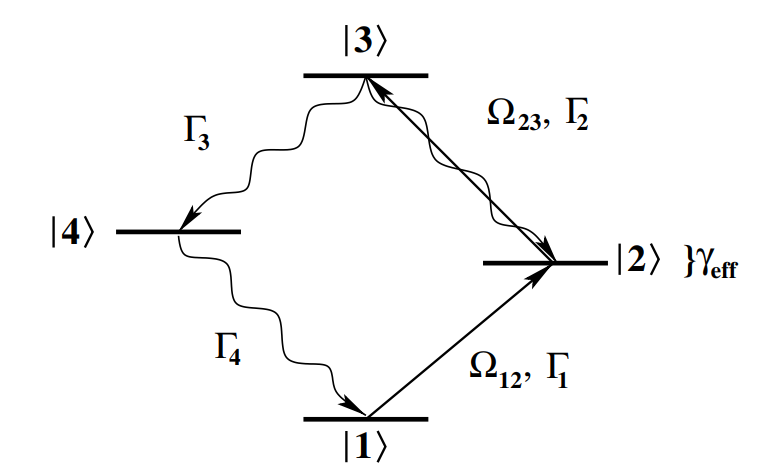


The effective decay rate is:
$$
\Gamma_{eff}=\Gamma_{1} + \frac{\Omega_{23}^{2}}{\Gamma_{3}}
$$

Which yields a scattering rate of:
$$
\Gamma_{scat}=\rho_{22}\Gamma_{eff}
$$



Now we need to slightly tweak the simulation process:

* Instead of having one photon absorption we are going to have 2. However, we can set the cooling and quenching lasers to have different polarities, thus increasing the probability of the two emissions being on the same direction.

* We are going to neglect the probability of exciting the cooling and quenching laser in two different directions. This approximation might be source of error later on, and should be properly accounted for by computing all of the clebch-gordan coefficients for the quenching laser.

* The 2 photon emissions will be independent from each other, and isotropic.

* We are assuming that the inensity of the quenching beams is constant across the width of the cooling laser.


Based on the paper [insert paper] the double recoil affects the results substantially and can't be dealt with analitically.

# Implementation

There are 6 possible directions for the cooling laser to hit the atom. Since the probabilities of each direction will be proportional to the excited state population let's break it down.

$$\rho_{ee}=\frac{\Omega_{12}^{2}}{2\Omega_{12}^{2}+\Gamma_{eff}^{2}+4\delta^{2}}$$

and remember $\delta = \delta_{L} - \vec{k}  \vec{v} + \frac{g_{j} m_{j}\mu_{B}}{\hbar} \vec{\nabla}(B)  \vec{x}$



$$
\Omega_{12}^{2}=\Omega_{0}^{2}exp(-\frac{r_{e_{i}}^{2}}{w^2})
$$

where $r_{e_{i}}$ is the perpendicular component of the position in the direction $e_{i}$ and w is the waist of our laser.

## Simulation


The simlation has been coded in Python, and it has been divided in 3 classes.

The first class, "Atom", acts as a container of the basic information about the structure of the atom we might want to deal with. That is its mass, the wavelenghts of each of its transitions as well as its effective scattering rate.

The second class, "MonteCarlo" , is the engine of the simulation. One can choose the ammount of particles to simulate, the timestep, and the ammount of timesteps. On top of that the intensity and width of the lasers is chosen, as well as the magnetic field gradient. The position and velocity of all the particles is initialized following a gaussian distribution of given deviation, and two empty arrays of $3 \times N_{Particles} \times N_{Timesteps}$ are created to store the position and velocity of all the particles at all times.
The class has 2 relevant methods. The first one being "cycle", it computes the probabilities of excitations for each of the particles by each direction of the laser, chooses one path at random, and indvidually updates the velocities accordingly. Note that for this process we only use matrix operations which result in a significant gain in efficiency compared to dealing with each particle individiually and then storing its information.
The second method is "evolve". It iterates over all the timesteps, performs a cycle and updates the postion and velocity of the atoms. Note that this mehtod also takes some array containing all $\delta_{L}$ at each timestep of the experiment so that we can model $\delta_{L}$ changing with time.
Once the simulation has been computed, this class will store the data of the trajectories of all the particles. Therefore it has built in functions to retrieve all the pertinent data such as average velocity or how many particles remain inside the sample holder during the experiment.

Finally, there is a class Optimizer that takes care of finding the optimal parameters for the experiment. We will explain it with more detail later on.


## Optimal parameters

The only term from $\rho_{ee}$ we can tune is $\delta$. Since $\delta = \delta_{L} - \vec{k}  \vec{v} + \frac{g_{j} m_{j}\mu_{B}}{\hbar} \vec{\nabla}(B)  \vec{x}$, we will need 2 things. The first thing is that $\delta_{L} \approx  \vec{k}  \vec{v}$ since that will minimize $\delta$ for particles close to $v$. However, we will find that for a particular arrangement of the polarization of the lasers and its direction we will succeed in trapping the atoms.
As we can see in the following plot, whenever $\delta_{L}$ is slightly inferior to $\vec{k}  \vec{v}$, we get that $\delta=0$ when the particle is about to leave the box.

In [2]:
k = Magnesium.k
deltaL = 2e7
plt.rcParams['text.usetex'] = False
def g(v=2.38, mag_grad=5.0,deltaL_effective_speed=1.75):
    N=50
    x = np.linspace(-0.002,0.002,N)
    magnetic_component=mag_grad*8.8e8
    dL=np.full(N,deltaL_effective_speed*k)
    plt.plot(1000*x,(k*v+magnetic_component*x)/1e6,label='left laser, pol=+1')
    plt.plot(1000*x,(k*v-magnetic_component*x)/1e6,label='right laser, pol=-1')
    plt.plot(1000*x,dL/1e6,label="$\delta_L$")
    plt.legend(loc="center left")
    plt.xlabel('Postion[mm]')
    plt.ylabel('$\delta [GHz]$')
    #plt.ylim(-1.5, 2.0)
    plt.show()

interactive_plot = interactive(g,v=(0.1,3.6),mag_grad=(3.0,6.0),deltaL_effective_speed=(0.1,3.6))
display(interactive_plot)


interactive(children=(FloatSlider(value=2.38, description='v', max=3.6, min=0.1), FloatSlider(value=5.0, descr…

## Results of the simulations

In the following section we are going to simultaneously introduce the results of the simulations and coment on them.

We will begin by initializing the "MonteCarlo" class and it's optimizer. By calling "optimizer.reset()" we will run the first simulation of the code. Note that we initialized $\delta_L$ as "None", which will by default compute the initial average position and velocity of all the particles and set:
$\delta_{L}^{Heuristic} = \vec{k}  \vec{v}_{average} + \frac{g_{j} m_{j}\mu_{B}}{\hbar} \nabla(B)  x_{target}$

Where we take  $x_{target}$ to be the distance at which we want to trap the particles. In this case we will take half of the size of the sample holder.


In [3]:
N=int(1e4)
ts=int(1e3+1)

In [4]:
monty_one=MonteCarlo(atom=Magnesium,
                 N=N,
                 timesteps=ts,
                 deltaL=None,
                 sigmar=5e-4,
                 sigmav=1.5,
                 dt=20e-6,
                 Omega12=5e5,
                 Magnetic_gradient=np.array([5,5,2.5]),
                 waist= 2e-3)

optimizer_one=Optimizer(monty_one)
optimizer_one.reset()
dL = monty_one.deltaL[0]
ds=np.linspace(-1,3, 100)
results=[]

for d in ds:
    monty_one.reset()
    monty_one.evolve(N,ts,np.full(1001,dL*d))
    results+=[monty_one.efficiency()[-1]]

fig_dL=px.line(x=ds,y=results)
fig_dL.update_layout(title="Efficiency after 20ms for a constant deltaL ",
                     xaxis_title="$\delta_{L} / \delta_{L}^{Heuristic}$",
                     yaxis_title="Efficiency")
fig_dL.show()

As seen in the previous graphic, this heuristic aproximation is not the most optimal one, nor keeping a constant value for $\delta_L$ will turn out to be the most optimal strategy. However, it already gives a far better performance than random guessing. It also gives us a good opportunity to study what is happening in our system.

In the following graphics we can see its performance.

On the first plot we have the average distance from the center of the sample holder as well their range from 10th to 90th percentile and the ammount of particles leaving per second (smoothed by a moving average).

One the second plot we have the average speed of the particles and the value of $\delta_L$ in function of time (note that $\delta_L$ is constant for now).

The function "plots" takes a "MonteCarlo" object generates the plots we just described. "w" represents the width of the moving average and t=-1 indicates that we only take the particles that will remain inside of the sample holder until the end of the experiment for consideration into the average. If we were to take t=0 we would get to see the results of the experiment if the sample holder was infinitely large. A particle is considered to “leave” the box when it’s distance from the origin is higher than the waist of the cooling laser - 2mm. 

In [5]:
monty_two=MonteCarlo(atom=Magnesium,
                 N=N,
                 timesteps=ts,
                 deltaL=None,
                 sigmar=5e-4,
                 sigmav=1.5,
                 dt=20e-6,
                 Omega12=5e5,
                 Magnetic_gradient=np.array([5,5,2.5]),
                 waist= 2e-3)

optimizer_two=Optimizer(monty_two)
optimizer_two.reset()
dL = monty_two.deltaL[0]

In [6]:
plots(monty_two,w=10,t=-1)

The final average Velocity is:0.37 m/s
The final average Distance from the Origin is:1.047 mm
In the end we still have 28.0% of the particles


From this data we can identify 4 different regimes. Note that even if the initial speed on the graphic is approximately 1.4 m/s, the real inital speed of the sample was 2.4 m/s. However the particles with high initial speed are less likely to stay within boundaries and therefore the initial average speed conditioned to staying within boundaries the whole experiment drops down significantly.

During the first 0.6ms the atoms just follow a linear trajectory; the amount of distance they cover is consistent with their initial average speed; during this period of time the probability of a particle having been efficiently slowed down by the lasers is still very low. At first, about half of the particles velocity will be somehow opposite to their position. Therefore during the first 0.1ms, we see how the average distance from the origin goes down. At that point the particles have reached an average distance from the origin of about 0.78mm, and it takes 0.5ms to reach the peak of particles leaving. This result is consistent with a velocity of $\frac{1.22}{0.5} \approx 2.4 $, which is exactly the initial velocity of our sample.
Note that the velocity of the whole sample at 0.6ms is 2m/s. This analysis just wants to show how during this period of time most particles haven't had time to turn around.

From 0.6ms up to 3ms the particles reach the “containing regime”. The particles reach an ideal average speed and postion for the laser cooling and the MOT to work efficiently. These particles might be called “well behaived” particles and are those at a specific distance from the origin and whose speed is targeted by the laser detunning. It is worth noticing that the particles that have started with very high speeds are not very likely to be contained efficiently by the MOT since they are too far from resonance. 

From 3ms on, all the particles are “well behaived” and one can see a logistic decrease of the distance from the origin. The event of a particle leaving the box is no longer likely during that phase.


Finally, at 10ms the “equilibrium regime” obtaines. Now barely any particle leaves, and average velocity and position are constant.

## Some other graphics

Here are some other useful graphics that can be consulted. They are all interactive in order to visualize the time evolution of the system.

The first one is a histogram of the velocity distribution of the atoms.

In [7]:
module_measure=[('module',None)]
figHV = TimeHist(monty_plot=monty_two,observable='V',measure=module_measure,xtitle='Velocity',nbins=15)
figHV.show()

After that a box diagram and a plot showing the distribuition in both axis of both the velocities and the positon of the particles.

In [8]:
TimeBox(monty_two,'V',sampleN=1000,sampleT=20,t=-1)
TimeCoords(monty_two,observable='V')
TimeBox(monty_two,'X',sampleN=1000,sampleT=20,t=-1)
TimeCoords(monty_two,observable='X')

Finally we have a phase space diagram of the modules of velocity vs position of the particles. As seen, the average distance to the center stabilizes at `1mm`. 

In [9]:
fig=PhaseSpace(monty_plot=monty_two,sampleN=250,sampleT=20,t=-1)

# Optimization Process

So far we have kept $\delta_L$ constant. However, the value we have chosen for deltaL is only resonant at the beggining of the process as the velocity of the particles quickly decreases. In the following section we are going to explore how would this result change using a non-constant $\delta_L$.


In [10]:
monty_three=MonteCarlo(atom=Magnesium,
                 N=N,
                 timesteps=ts,
                 deltaL=None,
                 sigmar=5e-4,
                 sigmav=1.5,
                 dt=20e-6,
                 Omega12=5e5,
                 Magnetic_gradient=np.array([5,5,2.5]),
                 waist= 2e-3)

optimizer_three=Optimizer(monty_three)
optimizer_three.reset()
dL = monty_three.deltaL[0]

In [11]:
print('Loading efficiency:',monty_three.efficiency()[-1])
plot_heuristic_dL(monty_three,0.1,0.9)

Loading efficiency: 0.2916


As seen in this graphic, the ideal heuristic $\delta_L$ has an initial phase where it decreases almost linearly, then has a pit and finally stabilizes at a constant value. In order to approximate this function in a reproductible way in the lab, we will use picewise functions. We hope to find the function for $\delta_L$ that optimizes loading efficiency.
In the code there is a two-step and a three-step piece-wise linear function. Since performing a brute force scan over all the possible parameters for our function would be too computationally expensive, we will make two assumptions.

First of all, we will assume that the last piece of the function will be constant, thus reducing by 1 the ammount of parameters to optimize. This assumption comes from the fact that for the last part of the experiment we are in the "stable regime", where we found out that velocity and position remain constant.

Secondly, instead of scanning over all possible parameters and choosing the best performing ones, we are just going to approximate our current heuristic $\delta_L$. This in turn will affect the evolution of the average velocity of our system over time. Therefore, the heuristic $\delta_L$ will also change, and a better approximation will be able to be made. By repeating this process iteratively we should get a good approximation of the ideal $\delta_L$.

Note that this procedure will only take into account the atoms that remain inside of the box during the whole simulation when computing the heuristic_dL. This comes from the fact that some of the atoms are too fast at the beggining of the simulation in order to be trapped and targetting them into resonance would decrease the likelyhood of trapping slower atoms.

However, targetting the average velocity for resonance might not be the best strategy, specially for higher temperature initial conditions, since some of the fast travelling escaping particles might be able to be trapped if we target them. In order to do so, we will implement the option to target a specific percentile of the velocities when computing the heuristic $\delta_L$. By targetting higher percentiles, we will be able to improve loading efficiency.

This new approach, although very fast at finding the parameters for the pice-wise linear function -in fact is just a matter of using OLS at every iteration of the method instead of running hundreds of simulations- has two new parameters we need to investigate: percentile and number of iterations of the method. Later on we will study how these affect the performance.



In [12]:
optimizer_three.optimize_dL(iterations=1,
                            measure_params_V=[('module',None),('quantile',0.8)],
                            measure_params_X=[('module',None),('mean',None)],
                            function='twostep_dL')

print('Loading efficiency:',monty_three.efficiency()[-1])
plot_heuristic_dL(monty_three,0.1,0.9)

Loading efficiency: 0.3771


As seen, after one iteration, the loading efficiency has improved, and the heuristic $\delta_L$ doesn't match the approximation we made anymore, it is slightly inferior.

Try to run the cell above multiple times in order to see what happens on multiple iterations of the method. You will notice that after some iterations -or maybe after the first one for low temperatures- the loading efficiency starts to decrease again.


# Performance
In this section we are going to investigate how does our method perform and what tradeoffs we need to make between loading efficiency and cooling efficiency.

The way we coded the simulation we can choose the deviation of a gaussian to initialize the system, but not a temperature per se. We might want to establish a relation between the temperature, the initial deviation for the velocity and the average velocity itself.
Note the following relations:

$$
<V^{2}>=<V_{x}^{2}>+<V_{y}^{2}>+<V_{z}^{2}>
$$
Since the velocities are independent and they follow a normal distribution with the same variance we can write:
$$
<V^{2}>=3<V_{x}^{2}>=3\sigma^{2}
$$

On the other hand, assuming an ideal gaz:
$$
\frac{1}{2}m_{atom}<V^{2}>=\frac{3}{2}k_{B}T
$$

Therefore we have that:
$$ T=\frac{m_{atom}}{k_{B}} \sigma^{2} $$

In [13]:
NN,tts=1000,751
monty_four=MonteCarlo(atom=Magnesium,
                 N=NN,
                 timesteps=tts,
                 deltaL=None,
                 sigmar=5e-4,
                 sigmav=1.5,
                 dt=20e-6,
                 Omega12=5e5,
                 Magnetic_gradient=np.array([5,5,2.5]),
                 waist= 2e-3)

optimizer_four=Optimizer(monty_four)
optimizer_four.reset()
dL = monty_four.deltaL[0]

kb=1.38e-23
def temp_to_std(monty,T):
    m=monty.atom.m
    return np.sqrt(kb/m *T)
    
def std_to_temp(monty,std):
    m=monty.atom.m
    return m/kb * std**2

print('A temperature of 2mk corresponds to a sigmav=',temp_to_std(monty_four,2e-3))


A temperature of 2mk corresponds to a sigmav= 0.826955293185504


Now we are going to call the method 'exhaustive_tries' of our Optimizer. The way it's going to work is that we are going to test which percentile works better for our method for different temperatures. We also need explore how many iterations of our method perform the best.

We are going to run 7 iterations of the method for each percentile for each temperature. We are going to keep track of what is the iteration that best performs loading efficiency wise, and what is the final temperature in that case.

With this information we will be able to draw conclusions on how many iterations of our method and which percentile to use and whether they depend on the initial temperature or not.

In [14]:
sigmas=np.linspace(0.8,1.5,num=60)
percentiles=np.linspace(0.5,0.8,num=20)
optimizer_four.exhaustive_tries(percentiles, sigmas)
eff_vs_sigmas = optimizer_four.results[:,:,0].max(axis=1)

0.8 0.5
0.8 0.5157894736842106
0.8 0.531578947368421
0.8 0.5473684210526316
0.8 0.5631578947368421
0.8 0.5789473684210527
0.8 0.5947368421052632
0.8 0.6105263157894737
0.8 0.6263157894736843
0.8 0.6421052631578947
0.8 0.6578947368421053
0.8 0.6736842105263159
0.8 0.6894736842105263
0.8 0.7052631578947369
0.8 0.7210526315789474
0.8 0.736842105263158
0.8 0.7526315789473685
0.8 0.768421052631579
0.8 0.7842105263157895
0.8 0.8
0.8118644067796611 0.5
0.8118644067796611 0.5157894736842106
0.8118644067796611 0.531578947368421
0.8118644067796611 0.5473684210526316
0.8118644067796611 0.5631578947368421
0.8118644067796611 0.5789473684210527
0.8118644067796611 0.5947368421052632
0.8118644067796611 0.6105263157894737
0.8118644067796611 0.6263157894736843
0.8118644067796611 0.6421052631578947
0.8118644067796611 0.6578947368421053
0.8118644067796611 0.6736842105263159
0.8118644067796611 0.6894736842105263
0.8118644067796611 0.7052631578947369
0.8118644067796611 0.7210526315789474
0.8118644067796611 

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(np.reshape(optimizer_four.results,(-1,6)))
df.columns = ['Loading Efficiency', 'Best Iteration', 'Final Velocity[m/s]', 'Initial Velocity std','Quantile','Final Temperature[microK]']
df=df.round({'Initial Velocity std':2})
df['Initial Temperature[mK]'] = df['Initial Velocity std'].apply(lambda x : 1e3*std_to_temp(monty_four,x))
df = df.astype({"Initial Velocity std": 'str'})
print(df[:4])

In [ ]:
fig = px.scatter(df, x="Final Temperature[microK]", y='Loading Efficiency',color="Initial Velocity std", hover_data=['Quantile'],size='Quantile')
fig.show()

In this graphic we can see Loading efficiency vs Final temperature for all runs of the experiment. Specially for low initial temperatures, we see a clear tradeoff between these two quantities. This is due to the fact that when targetting low speed atoms using a lower $\delta_L$ some of the quicker atoms leave the box before being cooled down.

In [ ]:
id_effsigma = df.groupby(['Initial Velocity std'])['Loading Efficiency'].transform(max) == df['Loading Efficiency']
fig_effsigma = px.line(df[id_effsigma], x="Initial Temperature[mK]", y='Loading Efficiency')
fig_effsigma.update_layout(title="Loading efficiency in funtion of initial temperature")
fig_effsigma.show()

In this graphic we can see how the initial temperature realtes to the loading efficiency. As expected, for lower temperatures it is easier to trap the atoms.

In [ ]:
id_effsigma = df.groupby(['Initial Velocity std'])['Loading Efficiency'].transform(max) == df['Loading Efficiency']
fig_effsigma = px.scatter(df[id_effsigma], x="Initial Temperature[mK]", y='Final Temperature[microK]',color='Loading Efficiency',hover_data=['Quantile'],trendline='ols')
fig_effsigma.update_layout(title="Final temperature in function of initial temperature")
fig_effsigma.show()

In this graphic we see the final temperature in function of the initial temperature. We are only considering the final temperatures corresponding to the quantiles that maximize efficiency for each initial temperature.

In [ ]:
df2 = df.copy()
df2['mean best iteration for init temp'] = df2.groupby(['Initial Velocity std'])['Best Iteration'].transform(np.mean)
px.scatter(df2,
           x='Initial Temperature[mK]',
           y='mean best iteration for init temp',
           color='Loading Efficiency',
           trendline='ols')

In [ ]:
id_bestquantile=df.groupby(['Initial Velocity std'])['Loading Efficiency'].transform(max) == df['Loading Efficiency']
px.scatter(df[id_bestquantile],x='Initial Temperature[mK]',y='Quantile',color='Loading Efficiency', hover_data=['Loading Efficiency'])